# 读取数据，去重

In [13]:
import pandas as pd
import numpy as np
import os
city = 'topsample'

dfs = []
for root, dirs, files in os.walk('chengjiao-%s'%city):
    #print(root, files, dirs)
    files.sort()
    for f in files:
        print(root, f)
        if f.endswith('.xls'):
            dfs.append(pd.read_excel(os.path.join(root, f), converters = {'成交价(元/平)':lambda x:float(x),
                                                                          '链家编号':str}))
        if f.endswith('.csv'):
            dfs.append(pd.read_csv(os.path.join(root, f), converters = {'成交价(元/平)':lambda x:float(x),
                                                                        '链家编号':str}))
dfs0 = dfs
dfs = []
#统一格式
for df in dfs0:
    df = df.rename(columns={'单价（元/平米）':'成交价(元/平)','所属小区':'小区','建筑面积：平米':'建筑面积',
                           '浏览(次)':'浏览（次）', '关注(人)':'关注（人）', '带看(次)':'带看（次）',
                           '所属下辖区':'下辖区', '房权所属':'产权所属', '房屋朝向':'朝向','调价（次）':'调价(次)',
                           '建成时间：年':'建成时间', '所属商圈':'商圈', '装修情况':'装修', '成交周期（天）':'成交周期(天)',
                           '房屋户型':'户型','产权年限':'土地年限', '楼层状态':'所在楼层', '挂牌价格（万）':'挂牌价格(万)',
                           '配备电梯':'电梯'})
    #去掉面积单位
    mj = df['建筑面积']
    mj_num = []
    for m in mj:
        m = str(m)
        if '㎡' in m:
            m = m[:m.find('㎡')]
        try:
            m = float(m)
        except:
            m = np.nan
        mj_num.append(m)
    df['建筑面积'] = mj_num
    #统一成交时间格式
    time = []
    for t in df['成交时间']:
        if '/' in t:
            t = '-'.join(t.split('/'))
        time.append(t)
    df['成交时间'] = time
    #去掉售价单位
    sj = df['售价(万)']
    sj_num = []
    for s in sj:
        s = str(s)
        if '万' in s:
            s = s[:s.find('万')]
        if '-' in s:
            #print(s)
            s = s.split('-')[-1]
        s = float(s)
        sj_num.append(s)
    df['售价(万)'] = sj_num
    df['成交价(元/平)'] = pd.to_numeric(df['成交价(元/平)'], errors='coerse')
    dfs.append(df)
    
df = pd.concat(dfs)
df = df.drop_duplicates(subset=['链家编号'])
df = df.loc[df['成交价(元/平)']> 1000]
len(df)

chengjiao-topsample/城市山林 2019-08-03-城市山林.xls
chengjiao-topsample/益田村 2019-08-03-益田村.xls
chengjiao-topsample/蔚蓝海岸 2019-08-03-蔚蓝海岸.xls
chengjiao-topsample/桃源村 2019-08-03-桃源村.xls
chengjiao-topsample/阳光棕榈园 2019-08-03-阳光棕榈园.xls
chengjiao-topsample/鼎太风华 2019-08-03-鼎太风华.xls
chengjiao-topsample/梅林一村 2019-08-03-梅林一村.xls


2314

In [ ]:
df.to_csv('%s.csv'%city, index=False)

# 计算全市日均价与成交量序列

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


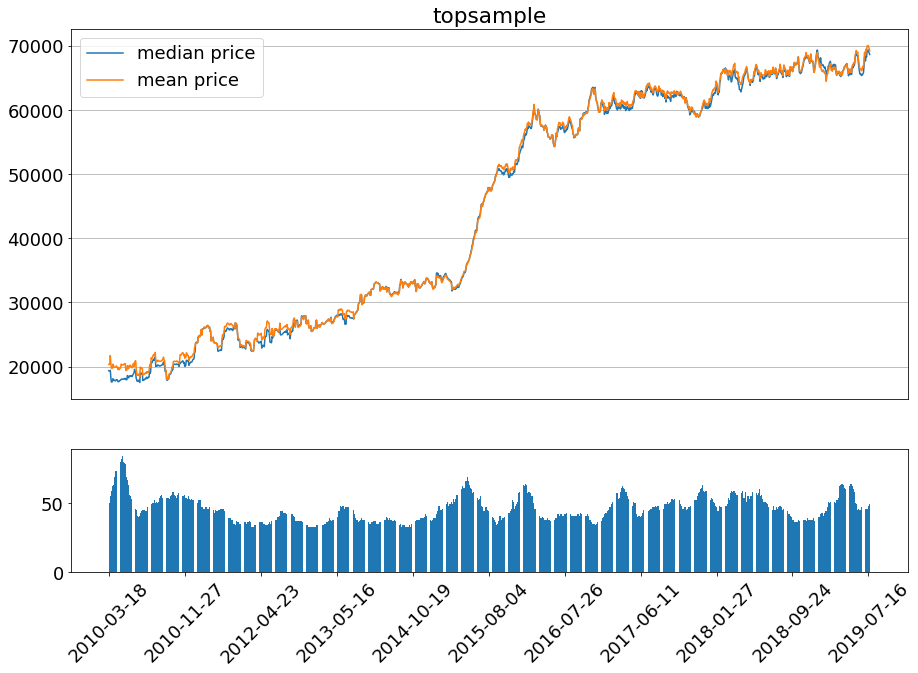

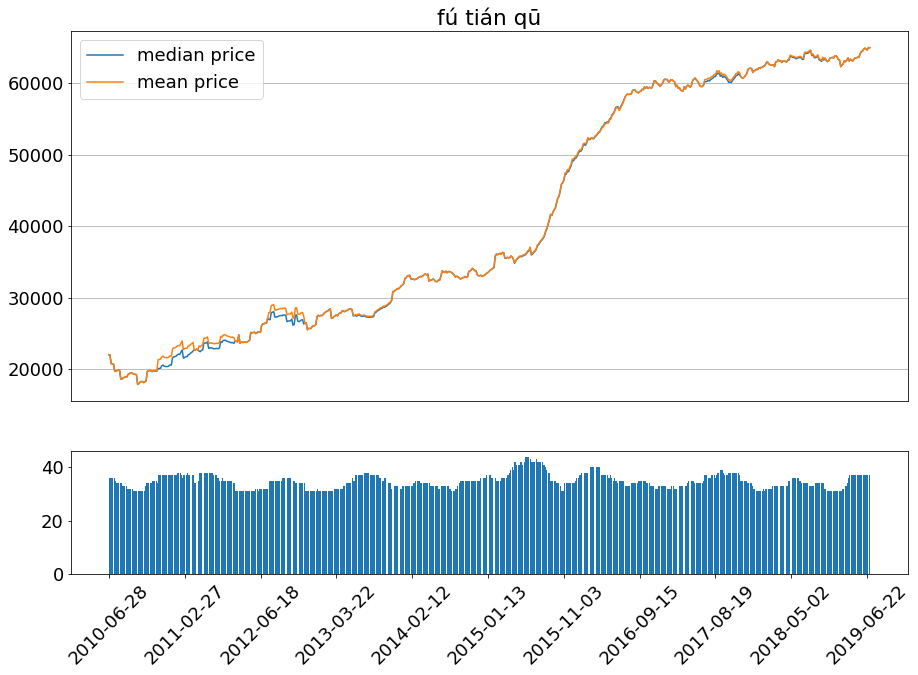

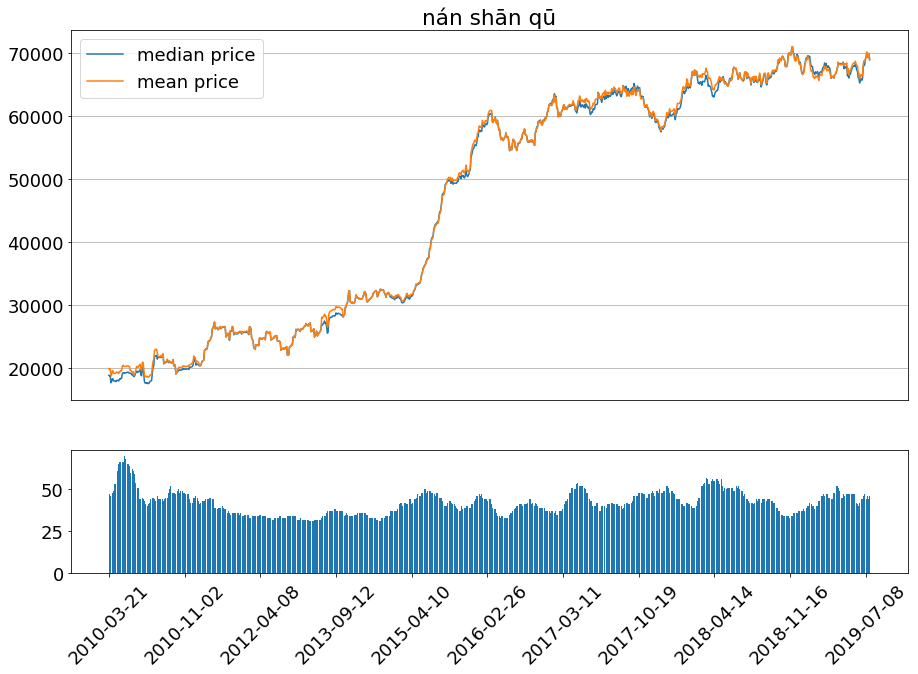

In [14]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
from pypinyin import pinyin
import numpy as np
MA = True
#MA = False
ma_length = 30
def get_moving_average(res, ma_length):
    volume_ma = []
    median_ma = []
    mean_ma = []
    for i in range(len(res) - ma_length):
        volume_ele = sum(res['volume'].iloc[i:i+ma_length])
        median_ele = 0
        mean_ele = 0
        for j in range(i, i + ma_length):
            median_ele += res['volume'].iloc[j] * res['median_price'].iloc[j]
            mean_ele += res['volume'].iloc[j] * res['mean_price'].iloc[j]
        volume_ma.append(volume_ele)    
        median_ma.append(median_ele/volume_ele)
        mean_ma.append(mean_ele/volume_ele)
    return pd.DataFrame({'volume':volume_ma, 'median_price':median_ma,  'mean_price':mean_ma}, 
                        index = res.index[ma_length:])

def plot(res, title, MA, ma_length):
    if  len(res)< 10:
        return
    if MA == True:
        res = get_moving_average(res, ma_length)
    plt.rcParams['font.sans-serif']=['SimHei']
    matplotlib.rc('font', size=18)
    matplotlib.rcParams['figure.figsize'] = [15, 10]
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    ax0 = plt.subplot(gs[0])
    ax0.plot(res['median_price'])
    ax0.plot(res['mean_price'])
    ax0.legend(['median price','mean price'])
    plt.xticks([])
    plt.title(title)
    plt.grid('on')
    ax1 = plt.subplot(gs[1])
    ax1.bar(res.index, res['volume'])
    xticks = ax1.xaxis.get_major_ticks()
    interval = len(xticks)// 10
    ax1.set_xticks(ax1.get_xticks()[::interval])
    plt.xticks(rotation=45)
    dir_name = os.path.join('fig', city)
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    plt.savefig(os.path.join(dir_name, title +'.png'))
    plt.show()
    plt.close()


gp = df.groupby(['成交时间'])['成交价(元/平)']
res=pd.DataFrame({"volume":gp.size(),"median_price":gp.median(), "mean_price":gp.mean()})
res = res.iloc[:len(res)-1,:]
title = pinyin(city)
title = " ".join([x[0] for x in title])
plot(res, title, MA, ma_length)
                        
def plot_district(district ='朝阳'):
    gp = df.loc[df['下辖区']==district].groupby(['成交时间'])
    res = pd.DataFrame({'volume':gp.size(),'mean_price':gp['成交价(元/平)'].mean(),
                        'median_price':gp['成交价(元/平)'].median()})
    res = res.iloc[:len(res) -1,:]
    
    title = pinyin(district)
    if district == '朝阳':
        title = 'chao yang'
    elif district == '长宁':
        title = 'chang ning'
    elif district == '闵行':
        title = 'min hang'
    else:
        title = " ".join([x[0] for x in title])
    plot(res, title, MA, ma_length)
districts = list(set(df['下辖区']))
for district in districts:
    plot_district(district)


In [ ]:
pd.options.display.max_columns = None
#df.loc[df['小区'].str.contains('团结湖南里')]
df.loc[df['小区'].str.contains('爱乐')].sort_values(by='成交时间', ascending=False)
#df.loc[df['小区'].str.contains('平乐园')].sort_values(by='成交时间', ascending=False)

In [ ]:
x=df.groupby('小区')
x_mean  = x.mean()
x_size = x.size()
#x_size
x_mean=x_mean.loc[x_size>=1]
x_mean=x_mean.sort_values(by='成交价(元/平)', ascending=False).loc[:,["建筑面积","成交价(元/平)","售价(万)"]]
x_mean

In [ ]:
x_mean.index[:10]

In [ ]:
df.sort_values('售价(万)', ascending=False).loc[:,["小区", "建筑面积","成交价(元/平)", "售价(万)"]]

In [ ]:
ma_length = 10
mean_price = df['成交价(元/平)'].mean()
price_std = df['成交价(元/平)'].std()
print('mean:', mean_price, 'std:', price_std)
threshold = 1.3
#high_df = df.loc[df['成交价(元/平)']>= mean_price + threshold * price_std]
#low_df =  df.loc[df['成交价(元/平)']< mean_price - threshold* price_std]
#medium_df = df.loc[df['成交价(元/平)']< mean_price + threshold * price_std]
#medium_df = medium_df.loc[medium_df['成交价(元/平)']>= mean_price - threshold * price_std]
df = df.sort_values('售价(万)')

high_df = df.iloc[:2000]
low_df = df.iloc[-2000:]
medium_df = df.iloc[2000:-2000]
print(len(high_df), len(low_df), len(medium_df))
def getPriceSeries(df):
    gp = df.groupby(['成交时间'])['成交价(元/平)']
    res=pd.DataFrame({"volume":gp.size(),"median_price":gp.median(), "mean_price":gp.mean()})
    res = res.sort_index()
    res = res.iloc[:len(res)-1]
    res = get_moving_average(res, ma_length)
    return res
highSeries=getPriceSeries(high_df)
mediumSeries=getPriceSeries(medium_df)
lowSeries=getPriceSeries(low_df)


In [ ]:
plt.plot(highSeries['mean_price']/highSeries['mean_price'][0])
plt.plot(mediumSeries['mean_price']/mediumSeries['mean_price'][0])
plt.plot(lowSeries['mean_price']/lowSeries['mean_price'][0])
plt.xticks(rotation=90)
plt.legend(['high','medium', 'low'])

In [ ]:
plt.plot(highSeries['median_price']/highSeries['median_price'][0])
plt.plot(mediumSeries['median_price']/mediumSeries['median_price'][0])
plt.plot(lowSeries['median_price']/lowSeries['median_price'][0])
plt.xticks(rotation=90)
plt.legend(['high','medium', 'low'])


In [ ]:
def plotAllDistrict(df, ma_length = 10):
    districts = list(set(df['下辖区']))
    legend = ['beijing']
    data = []
    gp = df.groupby(['成交时间'])['成交价(元/平)']
    res=pd.DataFrame({"volume":gp.size(),"median_price":gp.median(), "mean_price":gp.mean()})
    res = res.iloc[:len(res)-1,:]
    res = get_moving_average(res, ma_length)

    data.append(res)
    for district in districts:
        gp = df.loc[df['下辖区']==district].groupby(['成交时间'])
        res = pd.DataFrame({'volume':gp.size(),'mean_price':gp['成交价(元/平)'].mean(), 'median_price':gp['成交价(元/平)'].median()})
        res = res.iloc[:len(res) -1,:]
        res = get_moving_average(res, ma_length)
        if len(res) < 1:
            continue
        data.append(res)
        title = pinyin(district)
        if district == '朝阳':
            title = 'chao yang'
        elif district == '长宁':
            title = 'chang ning'
        elif district == '闵行':
            title = 'min hang'
        else:
            title = " ".join([x[0] for x in title])
        legend.append(title)
   
    for i in range(len(data)):
        plt.plot(data[i]['mean_price']/data[i]['mean_price'].iloc[0])
    plt.xticks(rotation=90)
    plt.legend(legend)
plotAllDistrict(df, 30)
    

In [ ]:
df1 = df.loc[df['售价(万)']>=400]
df2 = df1.loc[df1['售价(万)']<=500]
df2.to_csv('400-500.csv', index=False, encoding ='gbk')